In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Импорт

In [4]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
# метрики
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
# для ETS графиков
from pmdarima import auto_arima
# для поиска ARIMA моделей
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing #Модель Холта-Винтерса from statsmodels.tsa.ar_

## Подготовка функций для обработки данных и различных тестов

In [5]:
#Функция построения автокорреляции, частичной функцией автокорреляции и Q-статистик
def get_pdq(time_series):
  plot_acf(time_series)
  plot_pacf(time_series)
  plt.show()
  print("Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics")
  r,rac,Q = sm.tsa.acf(time_series, qstat=True)
  prac = pacf(time_series,method='ywmle')
  table_data = np.c_[range(1,len(r)), r[1:],rac,prac[1:len(rac)+1],Q]
  table = pd.DataFrame(table_data, columns=['lag', "AC","Q", "PAC", "Prob(>Q)"])
  print(table)

In [6]:
#тест Дики-Фуллера
def adf_test(timeseries):
  print("Results of Dickey-Fuller Test:")
  dftest = adfuller(timeseries, autolag="AIC")
  dfoutput = pd.Series(
      dftest[0:4],
      index=[
          "Test Statistic",
          "p-value",
          "#Lags Used",
          "Number of Observations Used",
          ],
      )
  for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [7]:
#Тест Квятковского-Филлипса-Шмидта-Шина
def kpss_test(timeseries):
  print("Results of KPSS Test:")
  kpsstest = kpss(timeseries, regression="c", nlags="auto")
  kpss_output = pd.Series(
      kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
      )
  for key, value in kpsstest[3].items():
    kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [8]:
#вывод метрик
def error_print(time_series,time_series2):
  error1 = mean_squared_error(time_series, time_series2)
  error2 = rmse(time_series, time_series2)
  error3 = mean_absolute_percentage_error(time_series, time_series2)
  print(f'MSE Error: {error1:11.10}')
  print(f'RMSE Error: {error2:11.10}')
  print(f'MAPE Error: {error3:11.10}')

## Чтение данных

In [9]:
!git clone https://github.com/samoletpanfilov/reinforcement_task.git

fatal: destination path 'reinforcement_task' already exists and is not an empty directory.


In [10]:
train = pd.read_excel('/content/reinforcement_task/data/train.xlsx')
test = pd.read_excel('/content/reinforcement_task/data/test.xlsx')
LME = pd.read_excel('/content/reinforcement_task/data/Индекс LME.xlsx')
CHMF = pd.read_csv('/content/reinforcement_task/data/CHMF Акции.csv')
MAGN = pd.read_csv('/content/reinforcement_task/data/MAGN Акции.csv')
NLMK = pd.read_csv('/content/reinforcement_task/data/NLMK Акции.csv')
trucking = pd.read_excel('/content/reinforcement_task/data/Грузоперевозки.xlsx')
stock = pd.read_excel('/content/reinforcement_task/data/Цены на сырье.xlsx')
build_materials = pd.read_excel('/content/reinforcement_task/data/Показатели рынка металла.xlsx')
macro = pd.read_excel('/content/reinforcement_task/data/Макропоказатели.xlsx')
indexes = pd.read_excel('/content/reinforcement_task/data/Показатели рынка металла.xlsx')
fuel = pd.read_excel('/content/reinforcement_task/data/Топливо.xlsx')
train.head()

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


In [11]:
test.head()

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500


In [12]:
print(CHMF.shape)
CHMF['Date'] = pd.to_datetime(CHMF['Date'], format = '%m/%d/%Y')
CHMF.head()

(1054, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,2023-03-31,"1,043.20","1,061.00","1,061.00","1,042.00",571.72K,-1.68%
1,2023-03-30,"1,061.00","1,074.60","1,084.80","1,058.00",1.30M,-1.27%
2,2023-03-29,"1,074.60","1,040.60","1,078.40","1,035.40",1.79M,3.53%
3,2023-03-28,"1,038.00","1,041.40","1,044.00","1,033.00",269.09K,-0.17%
4,2023-03-27,"1,039.80","1,036.20","1,042.60","1,032.20",410.74K,0.50%


In [13]:
CHMF['Date'].dt.year.value_counts() # данные только с 2019 года...

2021    255
2019    252
2020    250
2022    235
2023     62
Name: Date, dtype: int64

In [14]:
CHMF.info() # все признаки типа object 🔥

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1054 non-null   datetime64[ns]
 1   Price     1054 non-null   object        
 2   Open      1054 non-null   object        
 3   High      1054 non-null   object        
 4   Low       1054 non-null   object        
 5   Vol.      1053 non-null   object        
 6   Change %  1054 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 57.8+ KB


In [15]:
CHMF['Date'] = pd.to_datetime(CHMF['Date'], format = '%m/%d/%Y')
CHMF['Price']=CHMF['Price'].apply(lambda x: x.replace(',','')).astype(float)
CHMF['Open']=CHMF['Open'].apply(lambda x: x.replace(',','')).astype(float)
CHMF['High']=CHMF['High'].apply(lambda x: x.replace(',','')).astype(float)
CHMF['Low']=CHMF['Low'].apply(lambda x: x.replace(',','')).astype(float)
CHMF['Change %']=CHMF['Change %'].apply(lambda x: x.replace('%','')).astype(float)
CHMF['Vol.'].fillna('2.67M',inplace=True) # замена пропуска предыдущим значением
CHMF['Vol.']=CHMF['Vol.'].apply(lambda x: float(x.replace('K',''))*1000 if 'K' in x else float(x.replace('M',''))*1000000)
CHMF = CHMF.rename({'Date':'dt'}, axis=1)
CHMF = CHMF[::-1]
train_CHMF = pd.merge_asof(train, CHMF, on='dt')

In [16]:
MAGN = MAGN.rename(columns={'Дата': 'Date',
                    'Цена': 'Price',
                    'Откр.': 'Open', 'Макс.': 'High', 'Мин.':'Low', 'Объём': 'Vol.', 'Изм. %':'Change %'})

MAGN['Date'] = pd.to_datetime(MAGN['Date'], format = '%d.%m.%Y')
MAGN['Price']=MAGN['Price'].apply(lambda x: x.replace(',','.')).astype(float)
MAGN['Open']=MAGN['Open'].apply(lambda x: x.replace(',','.')).astype(float)
MAGN['High']=MAGN['High'].apply(lambda x: x.replace(',','.')).astype(float)
MAGN['Low']=MAGN['Low'].apply(lambda x: x.replace(',','.')).astype(float)
MAGN['Change %']=MAGN['Change %'].apply(lambda x: x.replace('%','').replace(',','.')).astype(float)
MAGN['Vol.']=MAGN['Vol.'].apply(lambda x: float(x.replace('K','').replace(',', '.'))*1000 if 'K' in x else float(x.replace('M','').replace(',', '.'))*1000000)
MAGN = MAGN.rename({'Date':'dt'}, axis=1)
MAGN = MAGN[::-1]

train_MAGN = pd.merge_asof(train, MAGN, on='dt')

In [17]:
train_trucking = pd.merge_asof(train, trucking, on='dt')

In [18]:
train_build_materials = pd.merge_asof(train, build_materials, on='dt')

In [19]:
macro = macro.drop('Базовый индекс потребительских цен на товары и услуги', axis=1)
macro = macro.fillna(method='backfill')
train_macro = pd.merge_asof(train, macro, on='dt')

In [20]:
LME = LME.iloc[:-1].rename({'дата': 'dt', 'цена': 'LME'}, axis=1)
LME['LME'] = LME['LME'].astype(int)
train_LME = pd.merge_asof(train, LME, on='dt')

In [21]:
fuel = fuel.rename(columns={'Цена на бензин': 'gas',
                    'Цена на дт': 'diesel'})
train_fuel = pd.merge_asof(train, fuel, on='dt')
train_fuel.fillna(method='backfill', inplace=True)

In [22]:
train_indexes = pd.merge_asof(train, indexes, on='dt')

In [23]:
train_stock = pd.merge_asof(train, stock.fillna(method='bfill'), on='dt')

Собираем все дополнительные данные в один общий train датасет

In [24]:
all_train = pd.merge(train_CHMF, train_MAGN.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_train = pd.merge(all_train, train_trucking.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_train = pd.merge(all_train, train_build_materials.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_train = pd.merge(all_train, train_macro.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_train = pd.merge(all_train, train_LME.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_train = pd.merge(all_train, train_fuel.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_train = pd.merge(all_train, train_indexes.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_train = pd.merge(all_train, train_stock.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))

In [25]:
all_train['day'] = all_train['dt'].dt.day
all_train['month'] = all_train['dt'].dt.month
all_train['year'] = all_train['dt'].dt.year

In [26]:
all_train.head(3)

,dt,Цена на арматуру,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x,Price_y,Open_y,...,"ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т",day,month,year
0,2015-01-05,32900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2015
1,2015-01-12,32500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,1,2015
2,2015-01-19,32000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,1,2015


## Визуализация данных

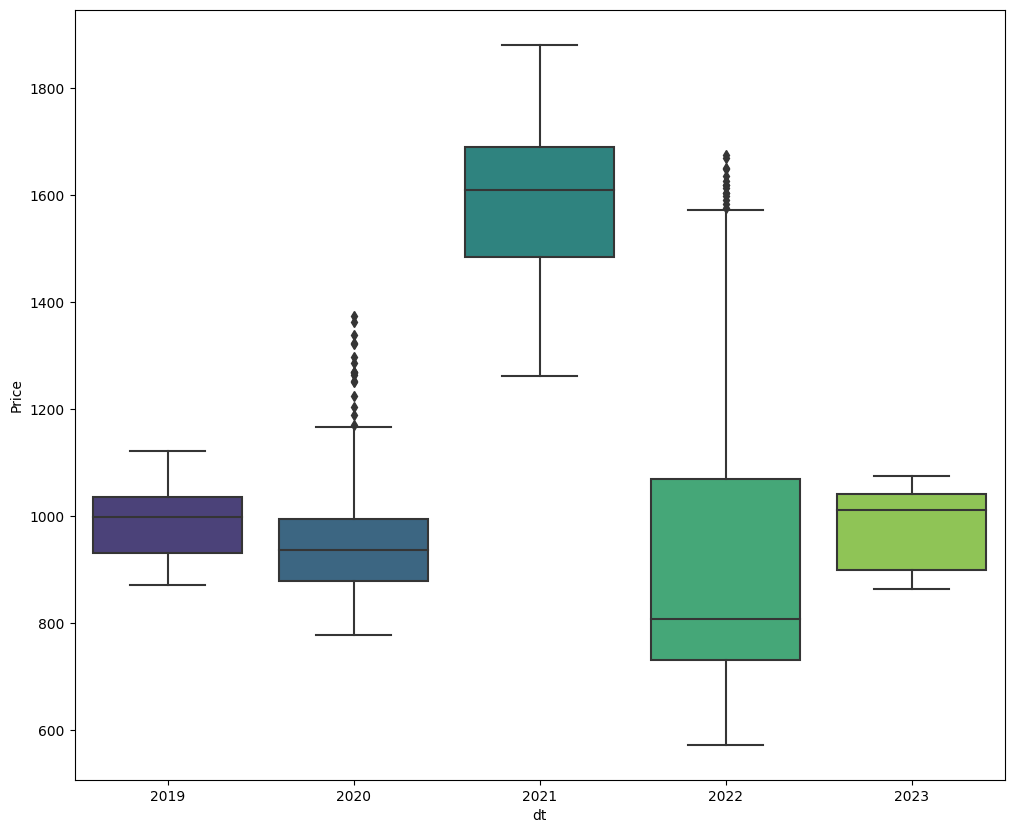

In [27]:
fig, (ax1) = plt.subplots(1,1,figsize=(12,10))

sns.boxplot(x = CHMF['dt'].dt.year, y = 'Price', data=CHMF, ax = ax1, palette = 'viridis');

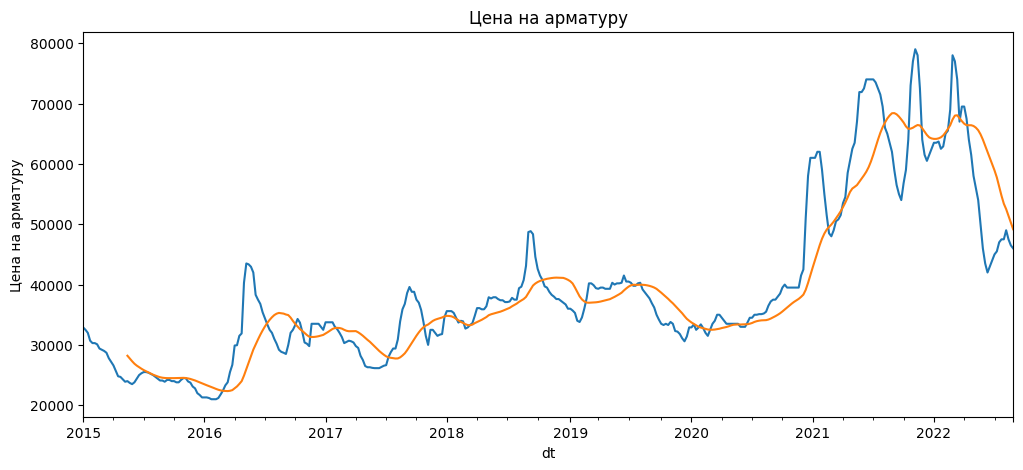

In [28]:
train.set_index('dt')['Цена на арматуру'].plot(figsize=(12,5), ylabel='Цена на арматуру', title='Цена на арматуру').autoscale(axis='x',tight=True)
train.set_index('dt')['Цена на арматуру'].rolling(window=20).mean().plot(figsize=(12,5), ylabel='Цена на арматуру', title='Цена на арматуру').autoscale(axis='x',tight=True)

<Axes: title={'center': 'Распределние по месяцам'}, xlabel='dt'>

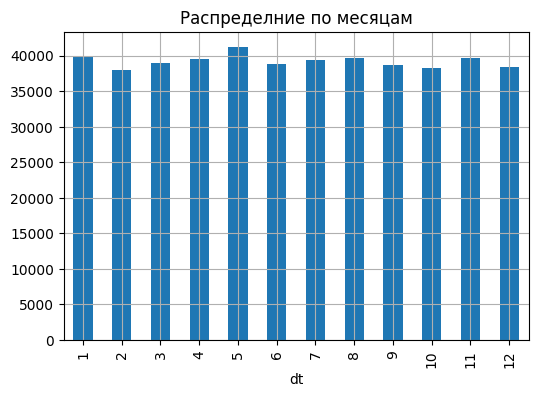

In [29]:
train.groupby(train['dt'].dt.month)['Цена на арматуру'].mean().plot(grid=True,title='Распределние по месяцам',kind='bar',figsize=(6,4))

Предполагали, что стоимость в летний сезон должна быть больше...

In [30]:
train['year']=train['dt'].dt.year
train['month']=train['dt'].dt.month
train['day']=train['dt'].dt.day

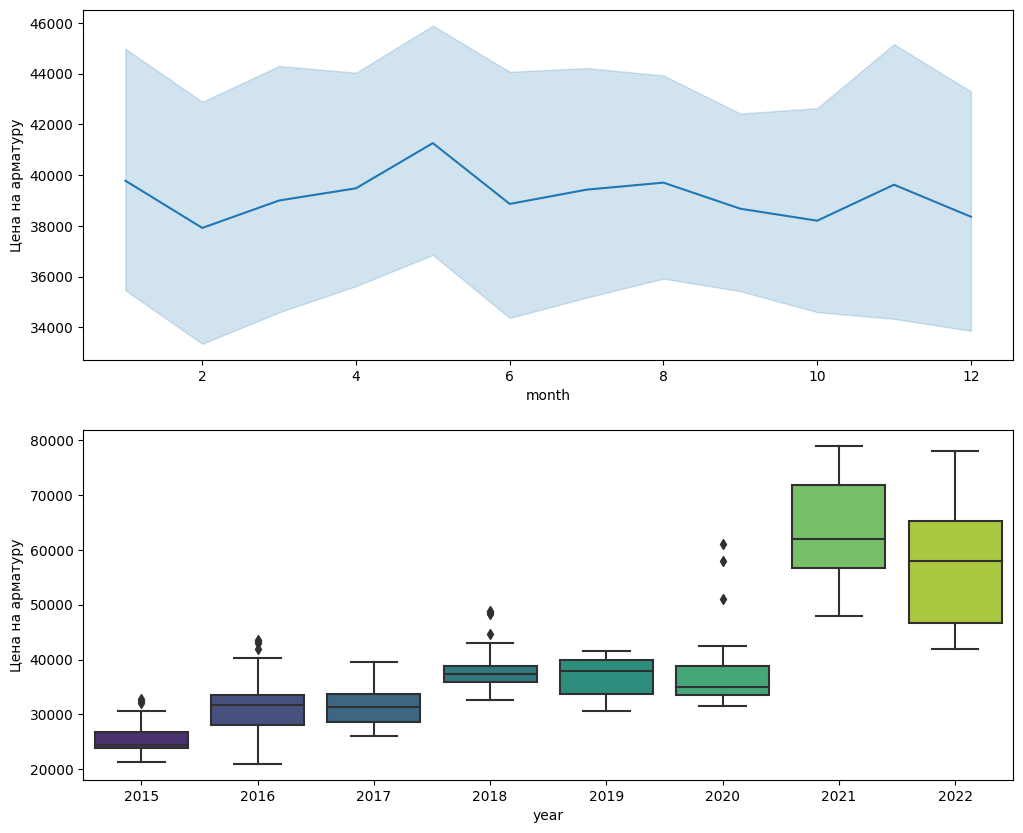

In [31]:
#
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))

sns.lineplot(x= 'month', y = 'Цена на арматуру', data=train, ax = ax1)
sns.boxplot(x = 'year', y = 'Цена на арматуру', data=train, ax = ax2, palette = 'viridis');

<Axes: xlabel='dt', ylabel='Цена на арматуру'>

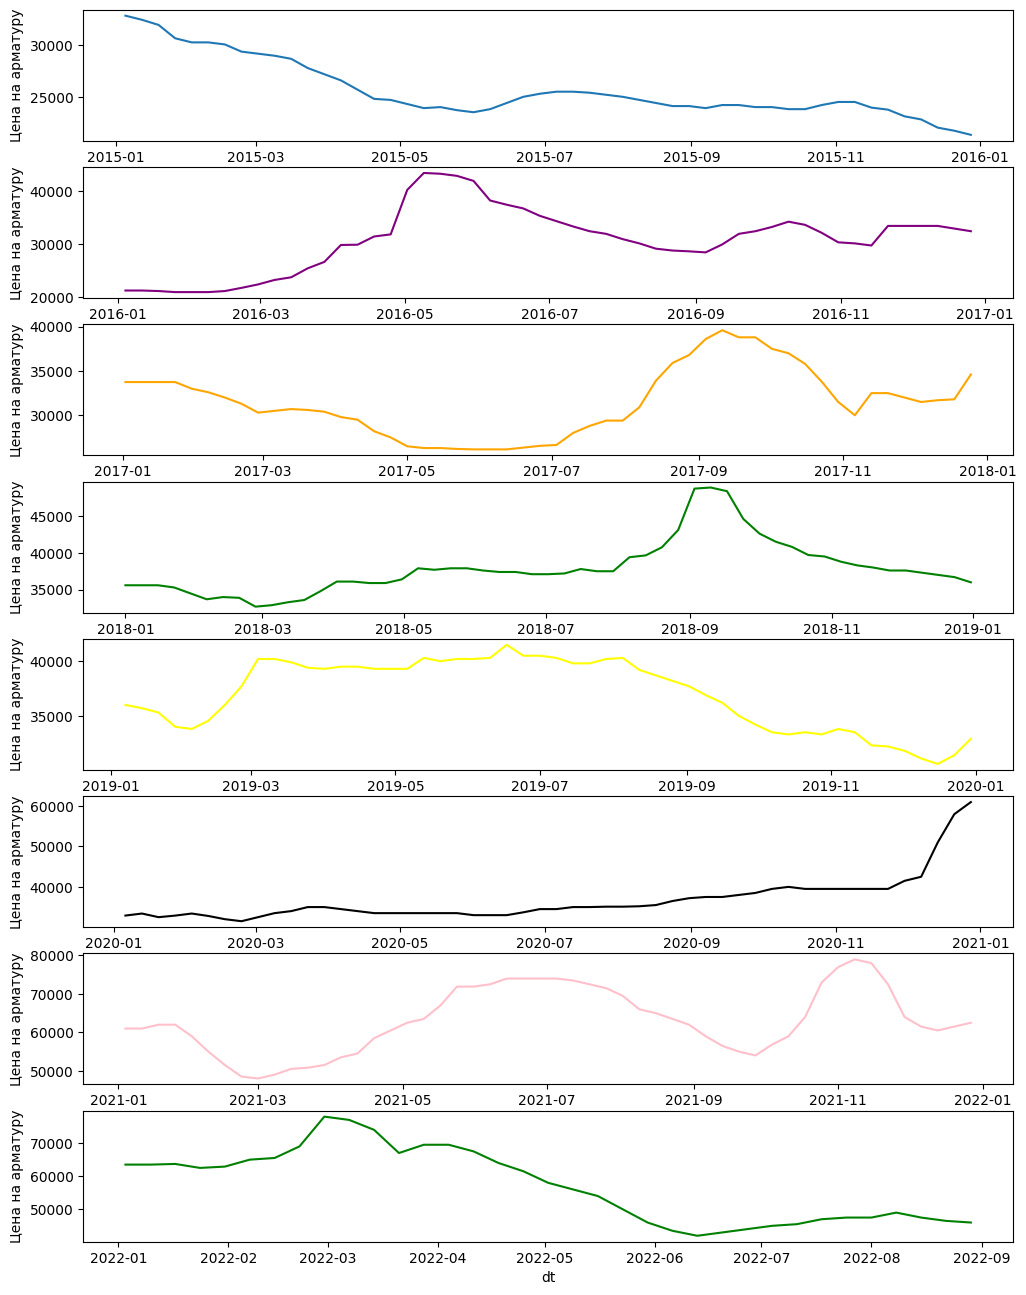

In [32]:
# GLOBAL COST - pattern of variation of values in the year
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8,1,figsize=(12,16))

sns.lineplot(x= 'dt', y = 'Цена на арматуру', data=train.loc[train['year']==2015], ax = ax1)
sns.lineplot(x= 'dt', y = 'Цена на арматуру', data=train.loc[train['year']==2016], ax = ax2, color='purple')
sns.lineplot(x= 'dt', y = 'Цена на арматуру', data=train.loc[train['year']==2017], ax = ax3, color='orange')
sns.lineplot(x= 'dt', y = 'Цена на арматуру', data=train.loc[train['year']==2018], ax = ax4, color='green')
sns.lineplot(x= 'dt', y = 'Цена на арматуру', data=train.loc[train['year']==2019], ax = ax5, color='yellow')
sns.lineplot(x= 'dt', y = 'Цена на арматуру', data=train.loc[train['year']==2020], ax = ax6, color='black')
sns.lineplot(x= 'dt', y = 'Цена на арматуру', data=train.loc[train['year']==2021], ax = ax7, color='pink')
sns.lineplot(x= 'dt', y = 'Цена на арматуру', data=train.loc[train['year']==2022], ax = ax8, color='green')

На всех графиках целевая переменная ведет себя совершенно поразному... 19 год - снижение в конце года. 20 - рост в конце. 21 - 2 пика в середине и в конце.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


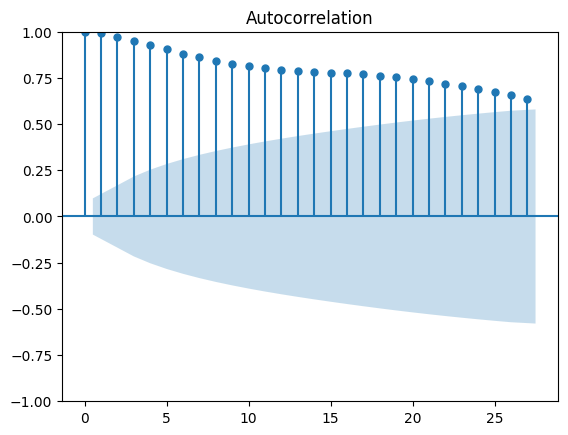

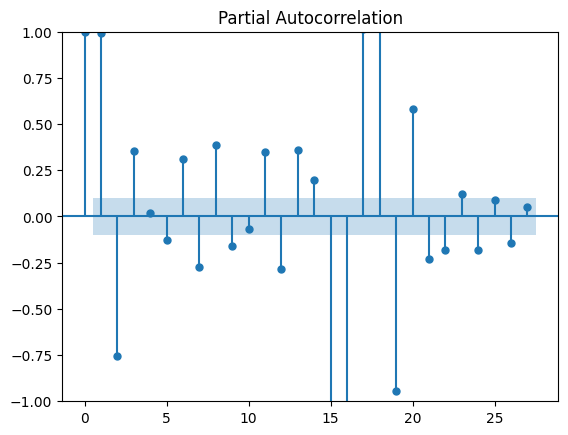

Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics
     lag        AC            Q       PAC       Prob(>Q)
0    1.0  0.991382   396.091548  0.991382   3.906302e-88
1    2.0  0.973677   779.121661 -0.533886  6.544567e-170
2    3.0  0.951220  1145.608042 -0.010897  4.636724e-248
3    4.0  0.927404  1494.852115  0.077386   0.000000e+00
4    5.0  0.903574  1827.217709 -0.004307   0.000000e+00
5    6.0  0.881266  2144.177415  0.079171   0.000000e+00
6    7.0  0.860609  2447.221047 -0.001359   0.000000e+00
7    8.0  0.842353  2738.284544  0.076019   0.000000e+00
8    9.0  0.826717  3019.360249  0.050884   0.000000e+00
9   10.0  0.813496  3292.215552  0.018501   0.000000e+00
10  11.0  0.802053  3558.130063  0.009032   0.000000e+00
11  12.0  0.792580  3818.469645  0.068851   0.000000e+00
12  13.0  0.785088  4074.571248  0.050774   0.000000e+00
13  14.0  0.780197  4328.146468  0.098445   0.000000e+00
14  15.0  0.776929  4580.255399 -0.023439   0.000000e+00
15  16.0 

In [33]:
get_pdq(train.set_index('dt')['Цена на арматуру'])

Проверка на стационарность
Стационарность означает, что статистические свойства временного ряда, то есть среднее значение,дисперсия и ковариация, не меняются с течением времени. Многие статистические модели требуют, чтобы ряды были стационарными,чтобы делать эффективные и точные прогнозы
Для проверки стационарности временного ряда будут использоваться два статистических теста - расширенный тест Дики Фуллера(«ADF»).
Тест ADF используется для определения наличия единичного корня в ряду и, следовательно, помогает понять, является ли ряд стационарным или нет. Нулевая и альтернативная гипотезы этого теста:
Нулевая гипотеза: серия имеет единичный корень.
Альтернативная гипотеза: у ряда нет единичного корня.
Если нулевую гипотезу отклонить не удалось, этот тест может предоставить свидетельство того, что ряд нестационарен. Создадим функцию для выполнения теста ADF проверки временного ряда.

In [34]:
adf_test(train.set_index('dt')['Цена на арматуру'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.925870
p-value                          0.319991
#Lags Used                       5.000000
Number of Observations Used    394.000000
Critical Value (1%)             -3.447057
dtype: float64
Test Statistic                  -1.925870
p-value                          0.319991
#Lags Used                       5.000000
Number of Observations Used    394.000000
Critical Value (1%)             -3.447057
Critical Value (5%)             -2.868904
dtype: float64
Test Statistic                  -1.925870
p-value                          0.319991
#Lags Used                       5.000000
Number of Observations Used    394.000000
Critical Value (1%)             -3.447057
Critical Value (5%)             -2.868904
Critical Value (10%)            -2.570693
dtype: float64


Основываясь на уровне значимости 0,05 и p-value теста ADF, нулевая гипотеза не может быть отклонена. Следовательно, ряд нестационарен.

<ipython-input-35-3ce761011215>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr().round(2), annot = True)


<Axes: >

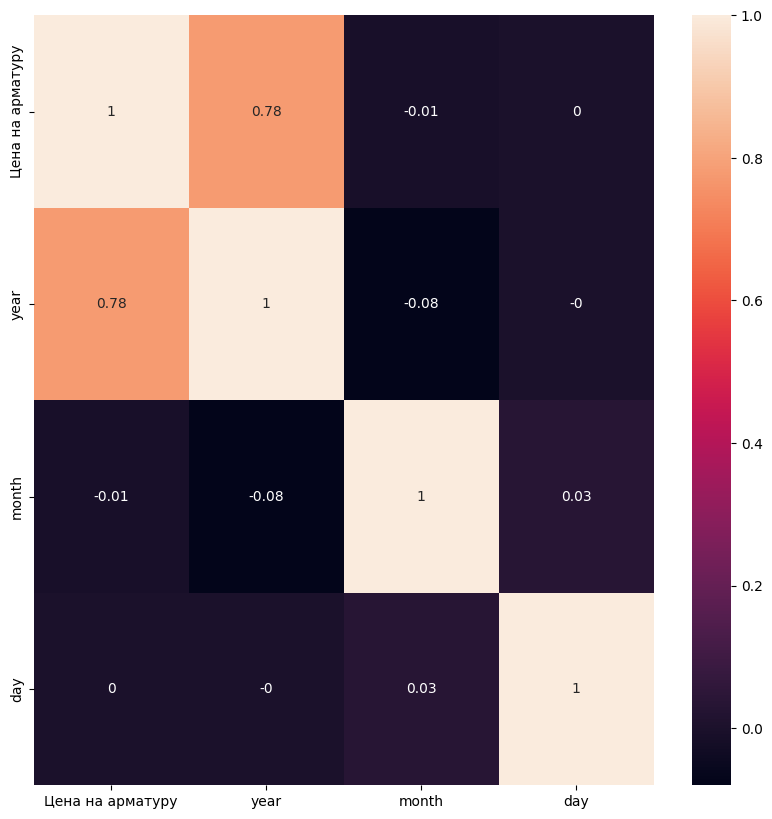

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr().round(2), annot = True)
# тепловая карта по результатам корреляцонного анализа

Сильное влияние на целевую переменную имеют добавленные признаки. При этом они также сильно скоррелированы друг с другом. Имеет смысл отсеить незначимые из них.

# Оценка значимости дополнительных параметров на предсказываемый параметр (target)


## Xgboost для оценки значимости

In [36]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 7
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
import seaborn as sns
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [37]:
X = all_train.drop(['Цена на арматуру'], axis=1)
y = all_train['Цена на арматуру']

In [38]:
y

0      32900
1      32500
2      32000
3      30700
4      30300
       ...  
395    47500
396    49000
397    47500
398    46500
399    46000
Name: Цена на арматуру, Length: 400, dtype: int64

In [39]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42, shuffle=True)
# ss = StandardScaler()
X_train_scaled = X_train.drop('dt', axis=1)
X_test_scaled = X_validation.drop('dt', axis=1)

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [41]:
model = XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.drop('dt', axis=1).columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

In [42]:
y_train

array([ 77,  60,  19,  45,  57,  42,  13,  90, 175, 154,  36, 134,  85,
       138, 102,   5,  69,  72, 117,  70,  88,  63,  16, 161,  20, 104,
       150, 169,  71,  93, 155,  89,  51, 106,  37, 136, 123,  69, 123,
       117,  15, 111,  84,  81, 128,  67,   3,  54,  66, 160,  47, 173,
        76,  62,  39, 143,  62,  60, 161, 139, 177,  91,  79,  82, 157,
        60, 172,  75,  56, 122,  78, 124,  26,  48, 102, 149,  43, 123,
        59,  17,  15,  97,  26,  98,  56, 119, 146, 121, 157, 130,  25,
        74, 167,  39, 177, 176, 177, 165, 173, 117,  99, 103,  67,  86,
        67,  29,  13,  35, 148, 102, 117,  49, 101, 151, 110,  43, 162,
        70, 150,  79, 158,  64,  70,  75,  58, 117, 127, 137,  60, 103,
        51, 125, 120,  23,  34, 180, 115, 165, 172, 152, 170,  25, 109,
       144,  21,  48, 131,  73,  68, 102,  42,  96, 105,  84,  18, 164,
        44,  40, 108, 102,  86,  33,  12,  22,  92, 113, 152,  83, 115,
        50,   1, 114, 107, 117, 103,  11, 147,  97,  61, 163,  4

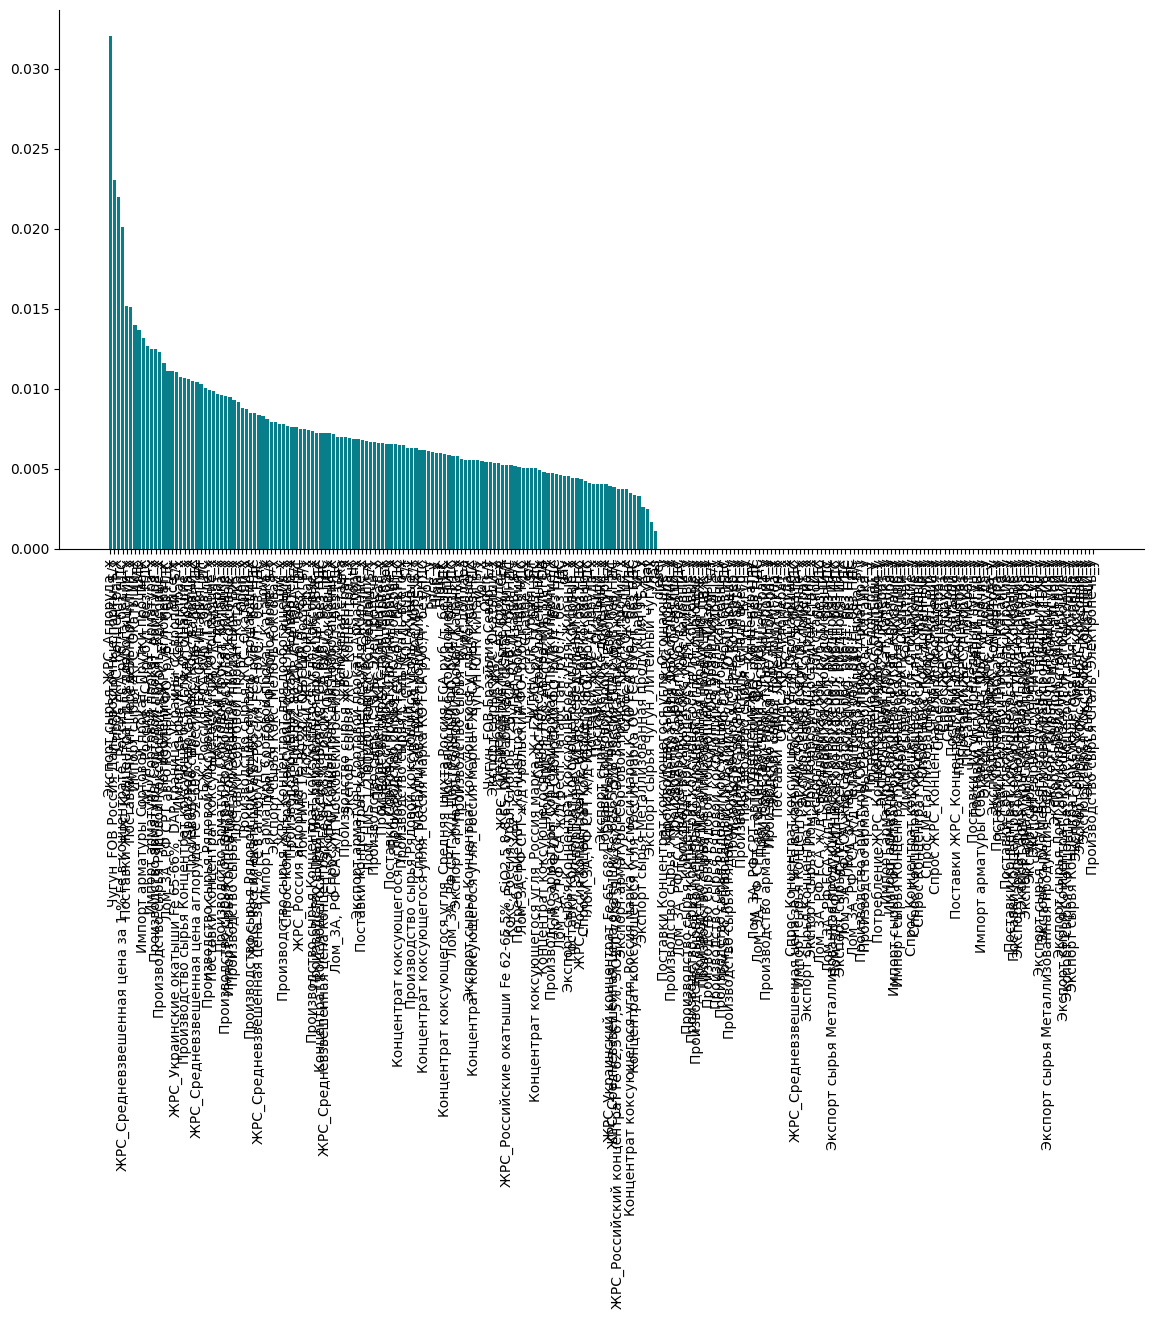

In [43]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
# plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [44]:
y_pred = model.predict(X_validation.drop('dt', axis=1))

In [45]:
to_plot = pd.DataFrame({'x': X_validation['dt'], 'y':y_validation, 'y_pred': y_pred})

In [46]:
to_plot

,x,y,y_pred
209,2019-01-07,36000,76
280,2020-05-18,33500,70
33,2015-08-24,24100,17
210,2019-01-14,35700,91
93,2016-10-17,33700,68
...,...,...,...
314,2021-01-11,61000,161
373,2022-02-28,78000,173
380,2022-04-18,64000,123
239,2019-08-05,40300,114


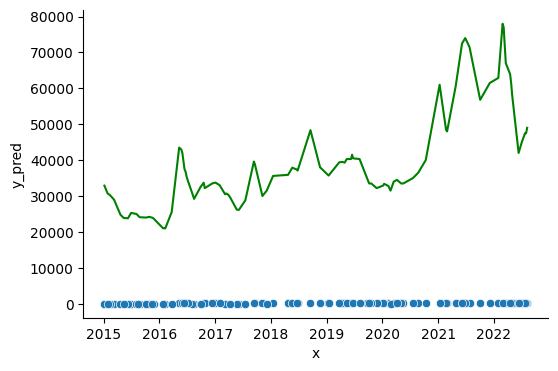

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(data=to_plot, x='x', y='y_pred', ax=ax)
p2 = sns.lineplot(data=to_plot, x='x', y='y', color='g', ax=ax)

<Axes: >

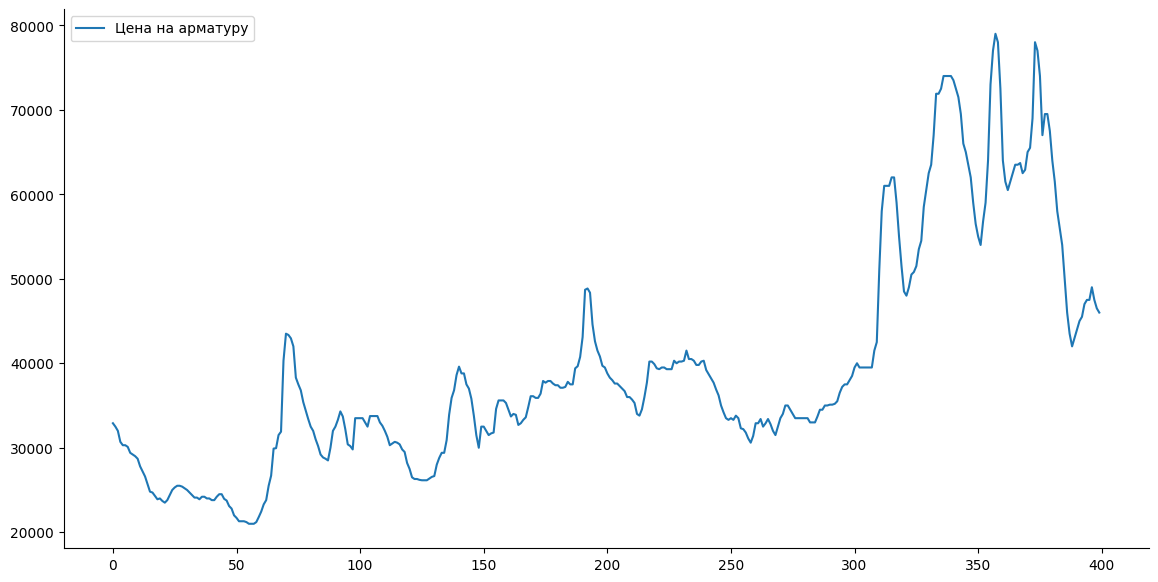

In [48]:
all_train.plot(y='Цена на арматуру')

## catboost

In [49]:
X, y = all_train.drop(['Цена на арматуру', 'dt'], axis=1), all_train['Цена на арматуру']

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, random_state=42, shuffle=True)

In [51]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [52]:
model = CatBoostRegressor(
    random_seed=42,
    logging_level='Silent',
    learning_rate=0.04,
    early_stopping_rounds=1000,
    iterations=10000
)

In [53]:
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    logging_level='Verbose',  # you can uncomment this for text output
    # plot=True,
);

Выходные данные были обрезаны до нескольких последних строк (5000).
2478:	learn: 10.2606634	test: 1526.1331995	best: 1526.1288647 (2474)	total: 33.3s	remaining: 1m 41s
2479:	learn: 10.2376361	test: 1526.1342050	best: 1526.1288647 (2474)	total: 33.3s	remaining: 1m 41s
2480:	learn: 10.2330984	test: 1526.1342400	best: 1526.1288647 (2474)	total: 33.3s	remaining: 1m 41s
2481:	learn: 10.2119301	test: 1526.1301126	best: 1526.1288647 (2474)	total: 33.4s	remaining: 1m 41s
2482:	learn: 10.1969231	test: 1526.1311103	best: 1526.1288647 (2474)	total: 33.4s	remaining: 1m 41s
2483:	learn: 10.1790043	test: 1526.1289632	best: 1526.1288647 (2474)	total: 33.4s	remaining: 1m 41s
2484:	learn: 10.1623661	test: 1526.1300397	best: 1526.1288647 (2474)	total: 33.4s	remaining: 1m 40s
2485:	learn: 10.1513325	test: 1526.1263456	best: 1526.1263456 (2485)	total: 33.4s	remaining: 1m 40s
2486:	learn: 10.1102411	test: 1526.1417875	best: 1526.1263456 (2485)	total: 33.4s	remaining: 1m 40s
2487:	learn: 10.1069819	test: 15

In [54]:
model.save_model('best')

In [55]:
model = CatBoostRegressor(
    random_seed=42,
    logging_level='Silent',
    learning_rate=0.04,
    early_stopping_rounds=1000,
    iterations=10000
)
model.load_model('best')

In [56]:
y_preds = model.predict(X_validation)

In [57]:
mean_squared_error(y_validation, y_preds)

2327181.1445518797

In [58]:
test_CHMF = pd.merge_asof(test, CHMF, on='dt')
test_MAGN = pd.merge_asof(test, MAGN, on='dt')
test_trucking = pd.merge_asof(test, trucking, on='dt')
test_build_materials = pd.merge_asof(test, build_materials, on='dt')
test_macro = pd.merge_asof(test, macro, on='dt')
test_LME = pd.merge_asof(test, LME, on='dt')

test_fuel = pd.merge_asof(test, fuel, on='dt')
test_fuel.fillna(method='backfill', inplace=True)

test_indexes = pd.merge_asof(test, indexes, on='dt')
test_stock = pd.merge_asof(test, stock.fillna(method='bfill'), on='dt')

In [59]:
all_test = pd.merge(test_CHMF, test_MAGN.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_test = pd.merge(all_test, test_trucking.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_test = pd.merge(all_test, test_build_materials.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_test = pd.merge(all_test, test_macro.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_test = pd.merge(all_test, test_LME.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_test = pd.merge(all_test, test_fuel.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_test = pd.merge(all_test, test_indexes.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))
all_test = pd.merge(all_test, test_stock.drop('Цена на арматуру', axis=1), on='dt', suffixes=('_x', '_y'))

all_test['day'] = all_test['dt'].dt.day
all_test['month'] = all_test['dt'].dt.month
all_test['year'] = all_test['dt'].dt.year

In [60]:
X_test = all_test.drop(['Цена на арматуру', 'dt'], axis=1)

In [61]:
y_test_preds = model.predict(X_test)

In [62]:
mean_squared_error(all_test['Цена на арматуру'], y_test_preds)

6149649.489793223

In [63]:
to_plot = pd.DataFrame({'x': all_test['dt'], 'y': all_test['Цена на арматуру'], 'y_pred': y_test_preds})

<Axes: xlabel='x'>

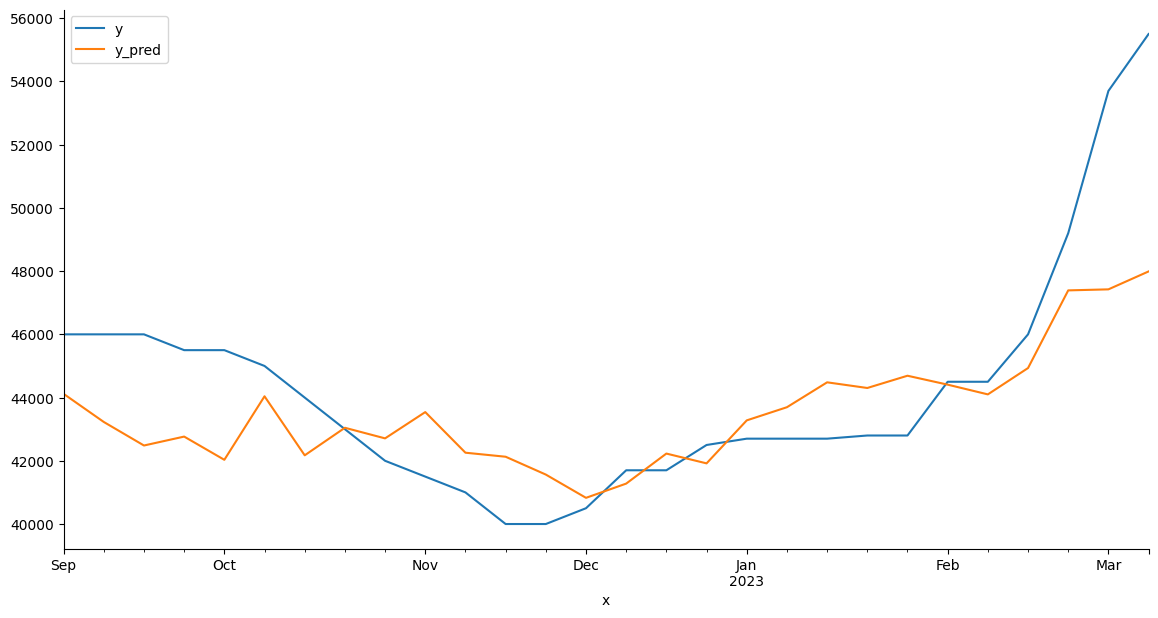

In [64]:
to_plot.plot(x='x')

In [65]:
def decision_prices(test):

    test = test.set_index('dt')
    tender_price = test['Цена на арматуру']
    decision = test['Объем']
    start_date = test.index.min()
    end_date = test.index.max()

    _results = []
    _active_weeks = 0
    for report_date in pd.date_range(start_date, end_date, freq='W-MON'):
        if _active_weeks == 0:  # Пришла пора нового тендера
            _fixed_price = tender_price.loc[report_date]
            _active_weeks = int(decision.loc[report_date])
        _results.append(_fixed_price)
        _active_weeks += -1
    cost = sum(_results)
    return cost # Возвращаем затраты на периоде

In [66]:
def volume(df, name):
    price = df[name].values
    out = [0]*len(df)

    i = 0
    while i < len(df):
        i += 1
        count = 0
        for j in range(i+1, min(i+11, len(df))):
            count += 1
            if price[i] >= price[j]:
                out[i] = count
                i += count - 1
                count = 0
                break
        else:
            out[i] = min(10, len(df) - i)
            i += 9
            count = 0
    out[0] = 1
    df['Объем'] = out
    return df

In [67]:
decision_prices(volume(train, 'Цена на арматуру'))

14738950

In [68]:
decision_prices(volume(test, 'Цена на арматуру'))

1192500

In [69]:
test['Цена на арматуру predict'] = y_test_preds

In [70]:
decision_prices(volume(test, 'Цена на арматуру predict'))

1215500

In [71]:
test

,dt,Цена на арматуру,Объем,Цена на арматуру predict
0,2022-09-05,46000,1,44118.034870
1,2022-09-12,46000,1,43228.309691
2,2022-09-19,46000,2,42483.704562
3,2022-09-26,45500,0,42765.809927
4,2022-10-03,45500,8,42031.399205
5,2022-10-10,45000,0,44040.127035
6,2022-10-17,44000,0,42173.338980
7,2022-10-24,43000,0,43044.655168
8,2022-10-31,42000,0,42709.331553
9,2022-11-07,41500,0,43540.774493
